Here I am fine tuning resnet-50 to get as accuracy as possible
# Suhail Bashir - 19COB502

In [1]:
from google.colab import files
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense,Flatten
from mpl_toolkits.axes_grid1 import ImageGrid
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
import shutil
import os

In [2]:
def colab_setup():
  #to mount drive with colab
  from google.colab import drive
  drive.mount('/content/drive')
  #getting dataset from drive to colab

  %cp -r "/content/drive/MyDrive/mini-imagenet/train.tar" /content/
  #untar train.tar
  !tar -xvf train.tar

In [3]:
colab_setup()

Streaming output truncated to the last 5000 lines.
train/n07584110/n0758411000001191.jpg
train/n07584110/n0758411000000076.jpg
train/n07584110/n0758411000000417.jpg
train/n07584110/n0758411000000361.jpg
train/n07584110/n0758411000001140.jpg
train/n07584110/n0758411000000990.jpg
train/n07584110/n0758411000000624.jpg
train/n07584110/n0758411000000183.jpg
train/n07584110/n0758411000000152.jpg
train/n07584110/n0758411000000294.jpg
train/n07584110/n0758411000000941.jpg
train/n07584110/n0758411000000533.jpg
train/n07584110/n0758411000000819.jpg
train/n07584110/n0758411000000908.jpg
train/n07584110/n0758411000001175.jpg
train/n07584110/n0758411000000850.jpg
train/n07584110/n0758411000001080.jpg
train/n07584110/n0758411000001051.jpg
train/n07584110/n0758411000000270.jpg
train/n07584110/n0758411000001109.jpg
train/n07584110/n0758411000000328.jpg
train/n07584110/n0758411000000973.jpg
train/n07584110/n0758411000001087.jpg
train/n07584110/n0758411000000277.jpg
train/n07584110/n0758411000000038.jpg

In [7]:
#setting sizes for images
img_width = 84
img_height = 84

batch_size = 64

In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split

def move_files(src_folder, dest_folder, files):
    os.makedirs(dest_folder, exist_ok=True)
    for file in files:
        src_path = os.path.join(src_folder, file)
        dest_path = os.path.join(dest_folder, file)
        shutil.move(src_path, dest_path)

# Path to your dataset with different classes in subdirectories
dataset_path = '/content/train'

# Define the split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Get the list of all subdirectories (classes) in the dataset
class_folders = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]

for class_folder in class_folders:
    class_path = os.path.join(dataset_path, class_folder)

    # Get the list of all files in the current class folder
    all_files = os.listdir(class_path)

    # Split the files for the current class
    train_files, test_val_files = train_test_split(all_files, test_size=(val_ratio + test_ratio), random_state=42)
    val_files, test_files = train_test_split(test_val_files, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42)

    # Define the paths for the new class folders
    train_class_folder = os.path.join('/content/train_new', class_folder)
    val_class_folder = os.path.join('/content/val', class_folder)
    test_class_folder = os.path.join('/content/test', class_folder)

    # Move files to respective class folders
    move_files(class_path, train_class_folder, train_files)
    move_files(class_path, val_class_folder, val_files)
    move_files(class_path, test_class_folder, test_files)

print("Dataset split into train, validation, and test sets for each class.")


Dataset split into train, validation, and test sets for each class.


In [5]:
#path for training and testing directory
train_dir = "/content/train_new"
test_dir = "/content/test"

In [8]:
#setting training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 26880 files belonging to 64 classes.
Using 21504 files for training.


In [9]:
#setting validation datase
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 26880 files belonging to 64 classes.
Using 5376 files for validation.


In [10]:
#setting testing datase
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size,
)

Found 5760 files belonging to 64 classes.


In [11]:
class_names = train_ds.class_names
print(f"The classes that we have are {class_names}")

The classes that we have are ['n01532829', 'n01558993', 'n01704323', 'n01749939', 'n01770081', 'n01843383', 'n01910747', 'n02074367', 'n02089867', 'n02091831', 'n02101006', 'n02105505', 'n02108089', 'n02108551', 'n02108915', 'n02111277', 'n02113712', 'n02120079', 'n02165456', 'n02457408', 'n02606052', 'n02687172', 'n02747177', 'n02795169', 'n02823428', 'n02966193', 'n03017168', 'n03047690', 'n03062245', 'n03207743', 'n03220513', 'n03337140', 'n03347037', 'n03400231', 'n03476684', 'n03527444', 'n03676483', 'n03838899', 'n03854065', 'n03888605', 'n03908618', 'n03924679', 'n03998194', 'n04067472', 'n04243546', 'n04251144', 'n04258138', 'n04275548', 'n04296562', 'n04389033', 'n04435653', 'n04443257', 'n04509417', 'n04515003', 'n04596742', 'n04604644', 'n04612504', 'n06794110', 'n07584110', 'n07697537', 'n07747607', 'n09246464', 'n13054560', 'n13133613']


In [12]:
#checking the dimensions of each batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 84, 84, 3)
(64,)


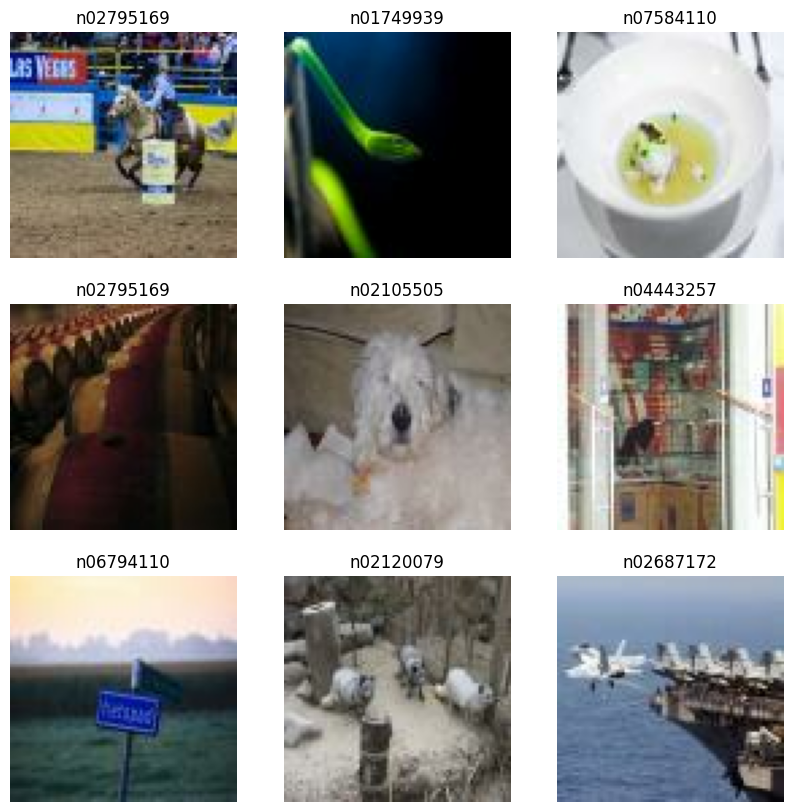

In [13]:
#plotting images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
#getting information regarding number of images in each class in each directory
import os
import pandas as pd

classes = 4

#make a count of the different classes
def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + '/' + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir,'test')
print(train_count)
print(test_count)

       n02966193  n04389033  n01770081  n02687172  n03047690  n07584110  \
train        420        420        420        420        420        420   

       n02108551  n03347037  n03854065  n03337140  ...  n02074367  n02823428  \
train        420        420        420        420  ...        420        420   

       n03476684  n06794110  n03527444  n02606052  n02113712  n07697537  \
train        420        420        420        420        420        420   

       n02091831  n02105505  
train        420        420  

[1 rows x 64 columns]
      n02966193  n04389033  n01770081  n02687172  n03047690  n07584110  \
test         90         90         90         90         90         90   

      n02108551  n03347037  n03854065  n03337140  ...  n02074367  n02823428  \
test         90         90         90         90  ...         90         90   

      n03476684  n06794110  n03527444  n02606052  n02113712  n07697537  \
test         90         90         90         90         90         90  

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
from tensorflow.keras.applications import resnet50
import tensorflow.keras.layers as tfl
preprocess_input_resnet = tf.keras.applications.resnet50.preprocess_input
global_layer = tfl.GlobalAveragePooling2D()

In [24]:
IMG_SIZE = (84,84)
def get_model(image_shape=IMG_SIZE):
    '''This function takes the argument image shape and returns the resnet model with all layers
        freezed and number of nodes of last layer is changed to number of classes that we have which is 4'''

    input_shape = IMG_SIZE + (3,)

    base_model = resnet50.ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')

    base_model.trainable = False

    inputs = tf.keras.Input(shape=input_shape)

    x = preprocess_input_resnet(inputs)

    x = base_model(x, training=False)

    x = global_layer(x) #global average pooling
    x = tfl.Dropout(0.2)(x)

    outputs = tfl.Dense(64,activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [25]:
model = get_model()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 84, 84, 3)]       0         
                                                                 
 tf.__operators__.getitem_2  (None, 84, 84, 3)         0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 84, 84, 3)         0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                           

In [26]:
#initial learning rate
base_learning_rate = 0.001

#compiling model with our loss function and metric that we use which is accuracy in our case
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [27]:
#saving model in this directory after training is over, so our best model is retreived.
!mkdir /content/Checkpoint

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=1e-6)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/Checkpoint/{epoch:02d}-{val_loss:.2f}-{accuracy:.2f}.hdf5',
    monitor='val_loss',
    mode='min',
    save_best_only=True)

mkdir: cannot create directory ‘/content/Checkpoint’: File exists


In [ ]:
history = model.fit(
    train_ds, epochs=20, callbacks=[model_checkpoint_callback, reduce_lr], validation_data=val_ds
)

Epoch 1/20
 22/336 [>.............................] - ETA: 9:25 - loss: 5.0866 - accuracy: 0.1179

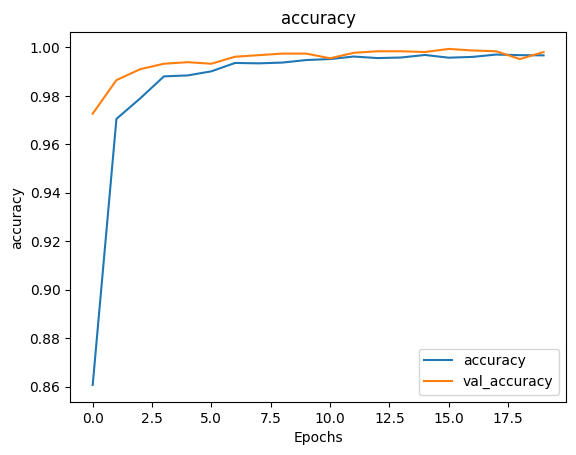

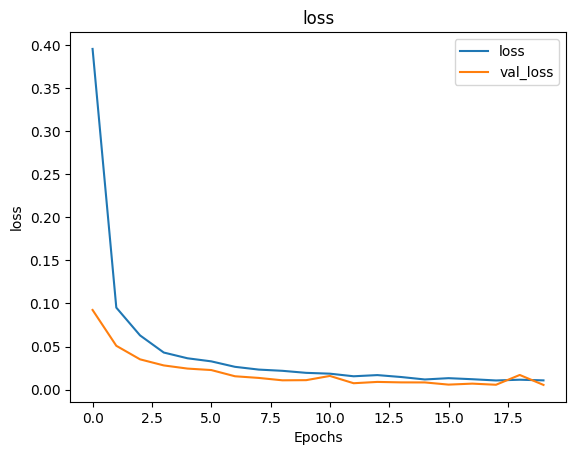

In [ ]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.title(string)
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
#optimezes the computation operation at the backend
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
print(model.metrics_names)

['loss', 'accuracy']


In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds)

31/31 [==============================] - 2s 65ms/step - loss: 0.0603 - accuracy: 0.9846


In [ ]:
print(f"The test loss for our model is {test_loss}")
print(f"The test accuracy for our model is {test_accuracy}")

The test loss for our model is 0.06029563397169113
The test accuracy for our model is 0.9846311211585999


In [ ]:
#function that plots our confusion matrix
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
import itertools
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.figure(figsize=(10,10))



    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)

    plt.colorbar()



    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)



    if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        cm = np.around(cm, decimals=2)

        cm[np.isnan(cm)] = 0.0

        print("Normalized confusion matrix")

    else:

        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, cm[i, j],

                 horizontalalignment="center",

                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()

    plt.ylabel('True label')

    plt.xlabel('Predicted label')

In [ ]:
Y_pred = model.predict(test_ds)

y_pred = np.argmax(Y_pred, axis=1)
y_pred

31/31 [==============================] - 2s 43ms/step


array([0, 2, 1, ..., 3, 2, 0])

In [ ]:
y_pred.shape

(1952,)

In [ ]:
#getting our model predictions and ground ready for plotting confusion matrix
y_pred = []
y_true = []

for image_batch, label_batch in test_ds:

   y_true.append(label_batch)

   preds = model.predict(image_batch)

   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 0s 24ms/step


In [ ]:
len(y_true)

31

Confusion matrix, without normalization


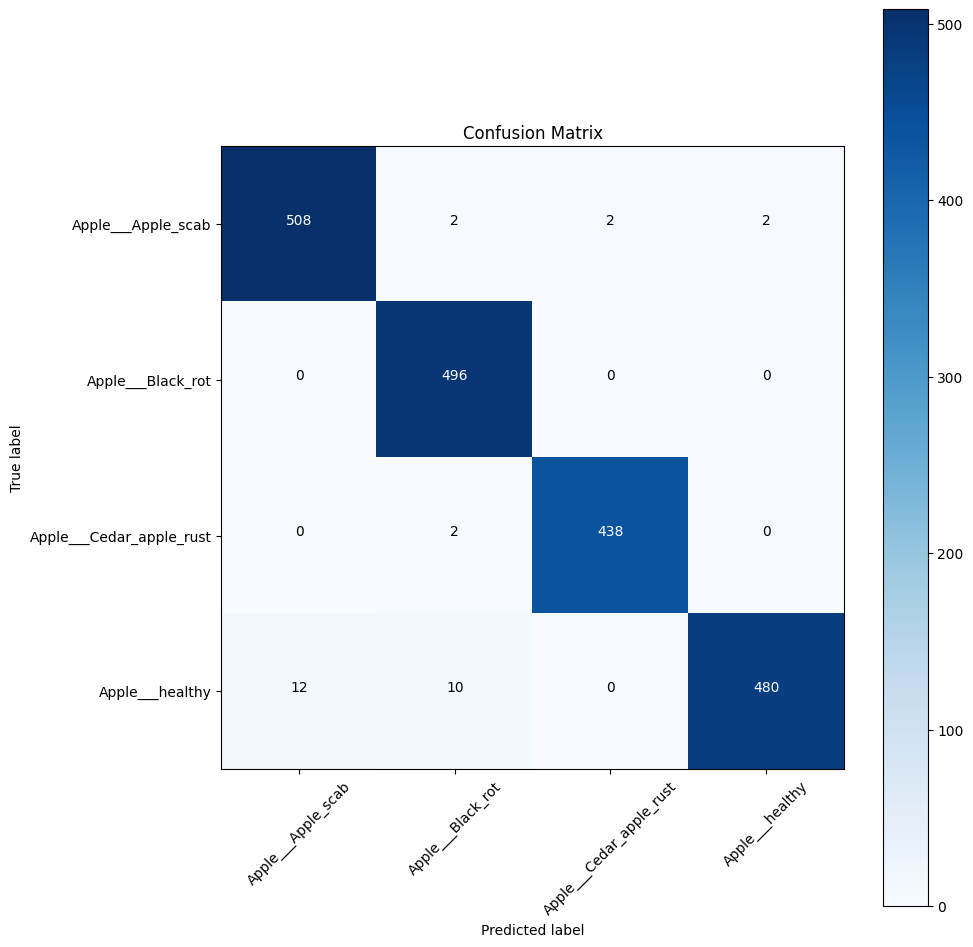

In [ ]:
cm1 = confusion_matrix(correct_labels, predicted_labels)

plot_confusion_matrix(cm1, class_names, normalize=False, title='Confusion Matrix')

Normalized confusion matrix


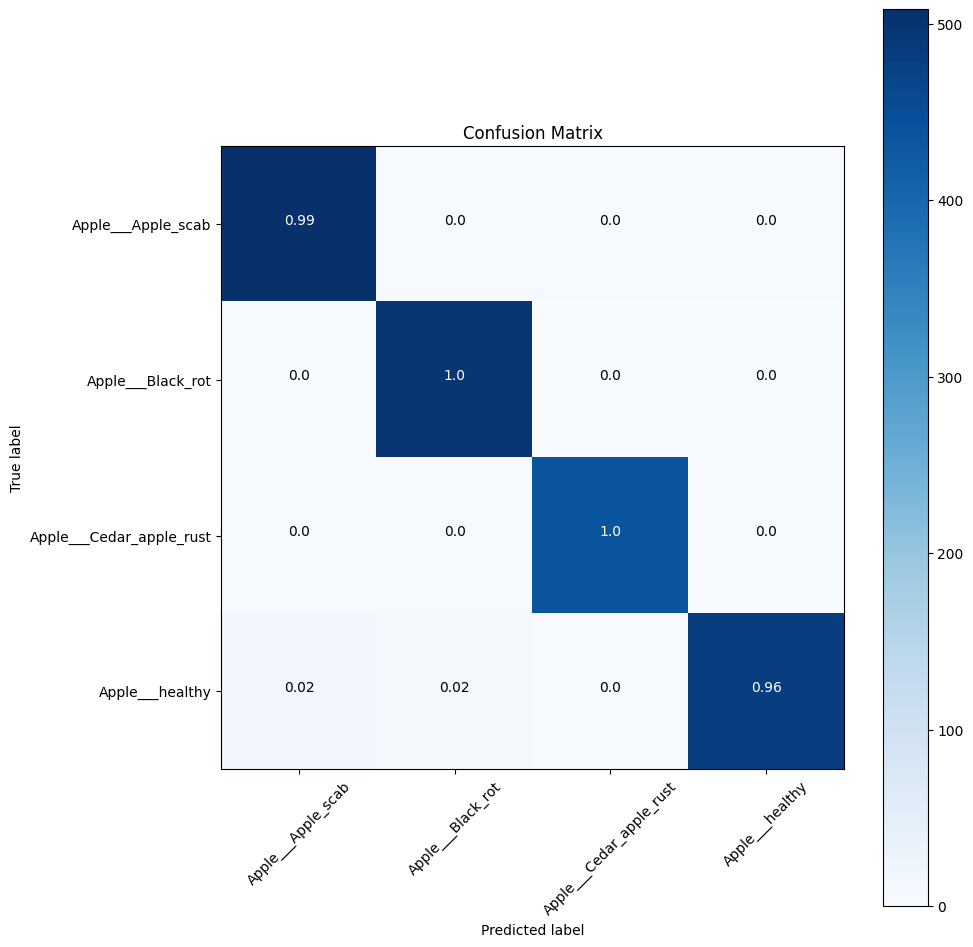

In [ ]:
cm1 = confusion_matrix(correct_labels, predicted_labels)

plot_confusion_matrix(cm1, class_names, normalize=True, title='Confusion Matrix')

In [ ]:
#averaged f1 score
f1_score(correct_labels, predicted_labels, average='weighted')

0.9866542338217879

In [ ]:
#the individual f1_score for all classes
f1_score(correct_labels, predicted_labels, average=None)

array([0.98640777, 0.9860835 , 0.99545455, 0.97975709])

In [ ]:
'Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy'

In [ ]:
#pre_process for ResNet-50
from tensorflow.keras.applications import resnet50
preprocess_input_resnet = tf.keras.applications.resnet50.preprocess_input

#pre_process for inception_v3
from tensorflow.keras.applications import inception_v3
preprocess_input_inception_net = tf.keras.applications.inception_v3.preprocess_input

#pre_process for MobileNet-v2
from tensorflow.keras.applications import mobilenet_v2
preprocess_input_mobilenet = tf.keras.applications.mobilenet_v2.preprocess_input


#pre_process for VGG-16
from tensorflow.keras.applications import vgg16
preprocess_input_vgg16 = tf.keras.applications.vgg16.preprocess_input

#pre_process for Xception
from tensorflow.keras.applications import xception
preprocess_input_xception = tf.keras.applications.xception.preprocess_input
